### **We use the prtrained model for glacier mapping**
all the validation scenes are used for validation:    
|model|miou |oa    |dice  |update_time|   
|-----|-----|-----|------|-----------|
|unet |0.895|0.962|0.941 |/|
|u2net|0.912|0.976|0.951 |/|
||||||


In [ ]:
import torch
import numpy as np
import rasterio as rio
from model import unet, u2net
from notebooks import config
from utils.imgShow import imsShow
from utils.img2patch import img2patch
from utils.metrics import metrics_segm
import pandas as pd


In [27]:
## load trained model
path_trained_model = 'model/trained/u2net_512/u2net_weights_1.pth'
# model = unet(num_bands=7)
model = u2net(num_bands_b1=6, num_bands_b2=1)
model.load_state_dict(torch.load(path_trained_model, weights_only=True))
model.eval();   ##


In [5]:
## data prepare: choose one scene for inference
print(len(config.paths_scene_val))  
# id = np.random.randint(0, len(config.paths_scene_val))
id = 4
path_scene = config.paths_scene_val[id]
path_dem = config.paths_dem_val[id]
path_truth = config.paths_truth_val[id]
# scene_id = path_truth.split('/')[-1].split('.')[0]
print('scene path:', path_scene)

13
scene path: data/dset/scene/scene_nor/l7_scene_08.tif


In [6]:
# ## read data
with rio.open(path_truth) as truth_rio:
    truth_arr = truth_rio.read(1)  # (H,W)
    profile_truth = truth_rio.profile
with rio.open(path_scene) as scene_rio, rio.open(path_dem) as dem_rio:
    scene_sdem_arr = np.concatenate([scene_rio.read(), dem_rio.read()], axis=0)
    scene_sdem_arr = scene_sdem_arr.transpose((1, 2, 0))  # (H,W,C)
scene_sdem_arr.shape


(1678, 1705, 7)

In [7]:
def model_infer(scene_arr, model):
    ### image to patches
    imgPat_obj = img2patch(img=scene_arr, patch_size=512, edge_overlay = 40)
    patch_arr_list = imgPat_obj.toPatch()
    # channel first and numpy array to torch tensor
    patch_list = [torch.from_numpy(patch.transpose(2,0,1)).float() for patch in patch_arr_list]  
    with torch.no_grad():  ## save 
        presult_list = [model(patch[np.newaxis, :]) for patch in patch_list]
    ## channel last and torch tensor to numpy array
    presult_arr_list = [np.squeeze(patch.detach().numpy().transpose(0,2,3,1), axis = 0) 
                                    for patch in presult_list ]       
    ## patch to image
    gla_pred_prob = imgPat_obj.toImage(presult_arr_list)
    gla_pred_cla = np.where(gla_pred_prob>0.5, 1, 0) 
    gla_pred_cla = gla_pred_cla.squeeze().astype(np.uint8) 
    
    return gla_pred_cla

gla_pred_cla = model_infer(scene_arr=scene_sdem_arr, model=model) 


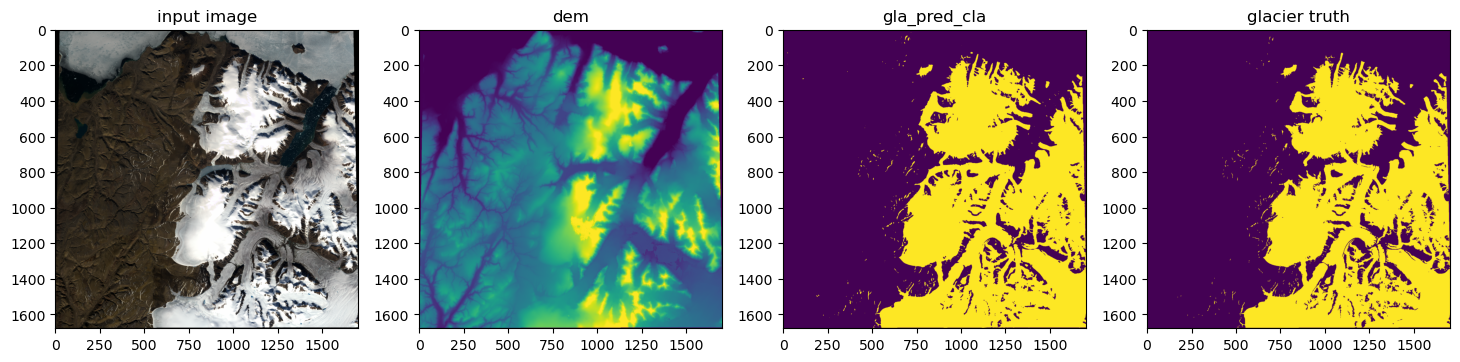

In [8]:
### show the results
imsShow([scene_sdem_arr, scene_sdem_arr[:,:,-1], gla_pred_cla, truth_arr], clip_list=[2, 2, 0, 0], 
        img_name_list = ['input image', 'dem', 'gla_pred_cla', 'glacier truth'],
         figsize=(18, 4))


In [9]:
metrics_sg = metrics_segm(cla_map=gla_pred_cla, 
                          truth_map=truth_arr, 
                          class_labels=[0, 1],
                          mean_mode=True)
metrics_gla = {'oa': metrics_sg.oa,
               'dice_mean': metrics_sg.dice['labels_mean'],
               'miou': metrics_sg.iou['labels_mean']}
metrics_gla


{'oa': np.float64(0.9740837961684592),
 'dice_mean': np.float64(0.97221075140893),
 'miou': np.float64(0.9460201158660477)}

In [10]:
metrics_scenes = {}
for path_scene, path_dem, path_truth in zip(config.paths_scene_val, config.paths_dem_val, config.paths_truth_val):
    print('scene path:', path_scene)
    with rio.open(path_truth) as truth_rio:
        truth_arr = truth_rio.read(1)  # (H,W)
        profile_truth = truth_rio.profile
    with rio.open(path_scene) as scene_rio, rio.open(path_dem) as dem_rio:
        scene_sdem_arr = np.concatenate([scene_rio.read(), dem_rio.read()], axis=0)
        scene_sdem_arr = scene_sdem_arr.transpose((1, 2, 0))  # (H,W,C)
    gla_pred_cla = model_infer(scene_arr=scene_sdem_arr, model=model) 
    metrics_sg = metrics_segm(cla_map=gla_pred_cla, truth_map=truth_arr, 
                              class_labels=[0, 1], mean_mode=True)
    metrics = {'oa': metrics_sg.oa,
                   'dice_mean': metrics_sg.dice['labels_mean'],
                   'miou': metrics_sg.iou['labels_mean']}
    metrics_scenes[path_scene.split('/')[-1].split('.')[0]] = metrics


scene path: data/dset/scene/scene_nor/l5_scene_01.tif
scene path: data/dset/scene/scene_nor/l5_scene_06.tif
scene path: data/dset/scene/scene_nor/l5_scene_11.tif
scene path: data/dset/scene/scene_nor/l7_scene_03.tif
scene path: data/dset/scene/scene_nor/l7_scene_08.tif
scene path: data/dset/scene/scene_nor/l7_scene_13.tif
scene path: data/dset/scene/scene_nor/l8_scene_05.tif
scene path: data/dset/scene/scene_nor/l8_scene_10.tif
scene path: data/dset/scene/scene_nor/l9_scene_02.tif
scene path: data/dset/scene/scene_nor/l9_scene_07.tif
scene path: data/dset/scene/scene_nor/l9_scene_12.tif
scene path: data/dset/scene/scene_nor/s2_scene_04.tif
scene path: data/dset/scene/scene_nor/s2_scene_09.tif


In [11]:
df_metrics_scenes = pd.DataFrame.from_dict(metrics_scenes, orient='index')
df_metrics_scenes.mean()


oa           0.975601
dice_mean    0.951350
miou         0.911692
dtype: float64

### write out prediction map

In [10]:
# # ### write the result to path
# path_gla_pred_cla = config.dir_result + scene_id + '_pred_cla.tif'   ## path to save result
# with rio.open(path_gla_pred_cla, 'w', **profile_truth) as dst:
#     dst.write(gla_pred_cla[:,:,0], 1)  # write to the first band


In [11]:
# ## load and show the image and the prediction map
# with rio.open(path_scene) as img_src, rio.open(path_gla_pred_cla) as pred_src, rio.open(path_dem) as dem_src:
#         scene_arr = img_src.read().transpose(1, 2, 0)  # change to channel last format
#         dem_arr = dem_src.read(1)
#         pred_arr = pred_src.read(1)   # read the first band (the classification result)
# imsShow([scene_arr, dem_arr, pred_arr], 
#         ['input image', 'dem', 'glacier prediction'], 
#         clip_list=[2, 2, 2], 
#         figsize=(10, 3))

